This notebook describes part of the PeeringDB dataset.  
It consists in IXP metadata (table `ix`), ASes metadata (table `net`), a directed Graph (`DiGraph`) and a table containing the graph's nodes metadata (table `nodes`).

In [38]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
from networkx.algorithms import bipartite

## Loading preprocessed data
Notes on the preprocessing: 
* All entries are uniquely defined with an index.
 * ASes: the index is the AS number (asn)
 * IXPs: a negative number that I attributed
* The graph is first built from infos present in `netixlan_set` of the API. This makes a bipartite graph (AS-IXP) with links weighted by the router port size (`speed` in the API)
* We want to derive a directed graph: we rely on ASes `info_ratio` attribute, that can take the values `Not Disclosed`, `Heavy In(out)bound`, `Mostly In(out)bound`, `Balanced`.
 * Inbound: a link is created with a weight=`speed` from IXP to AS. Another link of weight $(1-\beta)$*`speed` is created in the other direction
 * Outbound: a link is created with a weight=`speed` from AS to IXP. Another link of weight $(1-\beta)$*`speed` is created in the other direction
 * `Balanced` or `Not Disclosed`: A link in both direction with a weight=`speed`
 * Heavy categories: $\beta=\beta_H=0.95$, Mostly categories: $\beta=\beta_M=0.75$

In [39]:
path = "./"
prefix = "peeringdb_2_dump_"
date = "2021_03_01"

pickle_in = open(path+"nodes/"+prefix+date+".pickle", "rb")
nodes = pickle.load(pickle_in)
pickle_in.close()
nodes = nodes.loc[nodes["port_capacity"]>0] ##port capacity = sum of all ports
print("nodes table summary")
display(nodes.info())

pickle_in = open(path+"ix/"+prefix+date+".pickle", "rb")
ix = pickle.load(pickle_in)
pickle_in.close()
ix = ix.loc[ix["port_capacity"]>0]
print("ix table summary")
display(ix.info())

pickle_in = open(path+"net/"+prefix+date+".pickle", "rb")
net = pickle.load(pickle_in)
pickle_in.close()
net = net.loc[net["port_capacity"]>0]
print("net table summary")
display(net.info())

BETA_H = 0.95
BETA_M = 0.75

edgelist = open(path+"graph/"+format(BETA_H, '.4f')+"_"+format(BETA_M, '.4f')+"_"+prefix+date+".txt", "r")
DiGraph = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")


assert(len(nodes) == len(ix) + len(net))
assert(len(nodes) == len(DiGraph))

print("Total number of nodes:", len(nodes))
print("Total number of IXP:", len(ix))
print("Total number of ASes: ", len(net))
print("Total number of edges: ", len(DiGraph.edges()))

nodes table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12282 entries, 20940 to -893
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           12282 non-null  object 
 1   type           12282 non-null  object 
 2   prev_id        12282 non-null  int64  
 3   AStype         11472 non-null  object 
 4   region         12282 non-null  object 
 5   asn            12282 non-null  int64  
 6   port_capacity  12282 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 767.6+ KB


None

ix table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 810 entries, -1 to -893
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   proto_ipv6        810 non-null    bool  
 1   status            810 non-null    object
 2   url_stats         810 non-null    object
 3   id                810 non-null    int64 
 4   tech_email        810 non-null    object
 5   city              810 non-null    object
 6   policy_email      810 non-null    object
 7   tech_phone        810 non-null    object
 8   media             810 non-null    object
 9   proto_multicast   810 non-null    bool  
 10  ixf_last_import   127 non-null    object
 11  website           810 non-null    object
 12  updated           810 non-null    object
 13  net_count         810 non-null    int64 
 14  policy_phone      810 non-null    object
 15  proto_unicast     810 non-null    bool  
 16  region_continent  810 non-null    object
 1

None

net table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11472 entries, 20940 to 61437
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   status                        11472 non-null  object 
 1   looking_glass                 11472 non-null  object 
 2   route_server                  11472 non-null  object 
 3   netixlan_updated              11472 non-null  object 
 4   info_ratio                    11472 non-null  object 
 5   id                            11472 non-null  int64  
 6   policy_ratio                  11472 non-null  bool   
 7   info_unicast                  11472 non-null  bool   
 8   policy_general                11472 non-null  object 
 9   website                       11472 non-null  object 
 10  allow_ixp_update              11472 non-null  bool   
 11  updated                       11472 non-null  object 
 12  netfac_updated                7121 non

None

Total number of nodes: 12282
Total number of IXP: 810
Total number of ASes:  11472
Total number of edges:  63914


## Selecting the main connected component
Most graph algorithms behave best when the graph has a single connected component 

In [40]:
##I work only with the main connected component. Some entries of nodes, ix and net must be removed
##Main connected component.
#watch out casting DiGraph to Graph is not correct (delete doubled edges). For our use here it will be fine.
components = sorted(nx.connected_components(nx.Graph(DiGraph)), key=len, reverse=True) 
print("Number of connected components", len(components))
print("Percentage of nodes in the graph main connected component", 100.0*len(components[0])/DiGraph.number_of_nodes())
DiGraph = DiGraph.subgraph(components[0])

##Removing entries.
for i in range(1,len(components)):
    component = components[i]
    for node in component:
        #if node is an AS
        if node >= 0:
            net.drop(index=node, inplace=True)
            nodes.drop(index=node, inplace=True)
        #if node is an IXP
        if node < 0:
            ix.drop(index=node, inplace=True)
            nodes.drop(index=node, inplace=True)
            
assert(len(nodes) == len(ix) + len(net))
assert(len(nodes) == len(DiGraph))

Number of connected components 28
Percentage of nodes in the graph main connected component 99.22651034033545


The 7 node features are not already ready to be fed to the GCN.
The next step is therefore to **scale the data** in the best way possible.

## Scaling of the relevant node-features

In [41]:
#------------------------------------------------#
#   Function that creates the bipartite graph   #
#     with AS number as node feature and         #
#           weight as edge feature.              #
#      @param G : an empty graph                 #
#      @param filename : file to read            #
#      @return networkx graph : Graph as         #
#                            describe above      #
#------------------------------------------------#

def ajout_arete_bipartite_graph(G, filename):
    fichier = open(filename,"r")
    # Ajout des noeuds et arêtes 
    for ligne in fichier:
        tabligne = ligne.split(",")
        try:
            node1 = int(tabligne[0])
            node2 = int(tabligne[1])
            weight = float(tabligne[2])
            if node1 > 0:    
                G.add_edge(node1, node2, weight=weight)
        except ValueError:
            pass

In [42]:
FILE = "graph/0.9500_0.7500_peeringdb_2_dump_2021_03_01.txt"

G_bipartite = nx.DiGraph()
list_as = net['asn']
list_ixp = ix['asn']
G_bipartite.add_nodes_from(list_as, bipartite=0)
G_bipartite.add_nodes_from(list_ixp,  bipartite=1)

ajout_arete_bipartite_graph(G_bipartite, FILE)

In [43]:
components = sorted(nx.connected_components(nx.Graph(G_bipartite)), key=len, reverse=True) 
print("Number of connected components : ", len(components))
print("Number of connected nodes      : ", len(G_bipartite.nodes()))
print("Percentage of nodes in the graph main connected component : ", 100.0*len(components[0])/G_bipartite.number_of_nodes())
G_bipartite = G_bipartite.subgraph(components[0])

Number of connected components :  28
Number of connected nodes      :  12282
Percentage of nodes in the graph main connected component :  99.22651034033545


In [44]:
bottom_nodes, top_nodes = bipartite.sets(G_bipartite)

In [45]:
list_columns_ix = ['net_count', 'name', 'country', 
                   'notes', 'port_capacity', 'asn', 'ixf_net_count', 'id']

list_columns_net = ['info_type', 'info_ratio', 'info_scope', 'policy_general',
                    'info_traffic', 'port_capacity', 'ix_count']

### Ajout de la colonne `info_scope`

In [46]:
net['info_scope'].value_counts()

Regional         3614
Europe           1903
Not Disclosed    1527
Global           1264
Asia Pacific     1228
South America     690
North America     646
Africa            226
Australia         172
                   96
Middle East        41
Name: info_scope, dtype: int64

In [47]:
dataset_as = pd.DataFrame()
dataset_ixp = pd.DataFrame()

info_scope_scaled = net['info_scope'].map({"Regional":1/3, "Europe":2/3, "Not Disclosed":2/3, "Global":1, 
                                           "Asia Pacific":2/3, "South America":2/3, "North America":2/3, 
                                           "Africa":2/3, "Australia":2/3, "":2/3, "Middle East":2/3})

In [48]:
dataset_as['info_scope'] = info_scope_scaled
dataset_as['info_scope'].value_counts()

0.666667    6529
0.333333    3614
1.000000    1264
Name: info_scope, dtype: int64

In [49]:
not_disclosed_vs_port = pd.DataFrame(net['port_capacity'] [net['info_scope'] == 'Not Disclosed'])
not_disclosed_vs_port.describe()

,port_capacity
count,1.527000e+03
mean,2.019525e+04
std,1.020947e+05
min,1.000000e+00
25%,1.000000e+03
50%,8.200000e+03
75%,1.100000e+04
max,3.200000e+06


In [50]:
not_disclosed_vs_ixcount = pd.DataFrame(net['ix_count'] [net['info_scope'] == 'Not Disclosed'])
not_disclosed_vs_ixcount.describe()

,ix_count
count,1527.000000
mean,1.782580
std,1.848774
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,29.000000


In [51]:
info_scope_global = pd.DataFrame(net['ix_count'] [net['info_scope'] == 'Global'])
info_scope_global.describe()

,ix_count
count,1264.000000
mean,8.934335
std,25.353300
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,328.000000


### Ajout de la colonne `info_traffic`

In [52]:
net['info_traffic'].value_counts()

                3112
1-5Gbps         2093
5-10Gbps        1263
100-1000Mbps    1149
10-20Gbps       1055
20-50Gbps        900
50-100Gbps       555
100-200Gbps      313
20-100Mbps       231
1-5Tbps          178
0-20Mbps         149
500-1000Gbps     130
300-500Gbps      123
200-300Gbps      117
10-20Tbps         17
5-10Tbps          13
20-50Tbps          5
100+Tbps           3
50-100Tbps         1
Name: info_traffic, dtype: int64

In [53]:
nb_info_traffic = len(net['info_traffic'].value_counts())

info_traffic_scaled = net['info_traffic'].map({
                       "0-20Mbps":1/nb_info_traffic, "20-100Mbps":2/nb_info_traffic,
                       "100-1000Mbps":3/nb_info_traffic, "1-5Gbps":4/nb_info_traffic, 
                       "5-10Gbps":5/nb_info_traffic, "":6/nb_info_traffic, ## "" <=> 6/19, see former notebook
                       "10-20Gbps":7/nb_info_traffic, "20-50Gbps":8/nb_info_traffic,
                       "50-100Gbps":9/nb_info_traffic, "100-200Gbps":10/nb_info_traffic, 
                       "200-300Gbps":11/nb_info_traffic, "300-500Gbps":12/nb_info_traffic,
                       "500-1000Gbps":13/nb_info_traffic, "1-5Tbps":14/nb_info_traffic, 
                       "5-10Tbps":15/nb_info_traffic, "10-20Tbps":16/nb_info_traffic, 
                       "20-50Tbps":17/nb_info_traffic, "50-100Tbps":18/nb_info_traffic,
                       "100+Tbps":19/nb_info_traffic})

In [54]:
dataset_as['info_traffic'] = info_traffic_scaled
dataset_as['info_traffic'].value_counts()

0.315789    3112
0.210526    2093
0.263158    1263
0.157895    1149
0.368421    1055
0.421053     900
0.473684     555
0.526316     313
0.105263     231
0.736842     178
0.052632     149
0.684211     130
0.631579     123
0.578947     117
0.842105      17
0.789474      13
0.894737       5
1.000000       3
0.947368       1
Name: info_traffic, dtype: int64

### Ajout de la colonne `net_count` [IXP]

In [55]:
max_net_count = ix['net_count'].max()
net_count_scaled = [len(DiGraph[i])/max_net_count for i in DiGraph.nodes() if i < 0]

dataset_ixp['net_count'] = net_count_scaled

array([[<AxesSubplot:title={'center':'net_count'}>]], dtype=object)

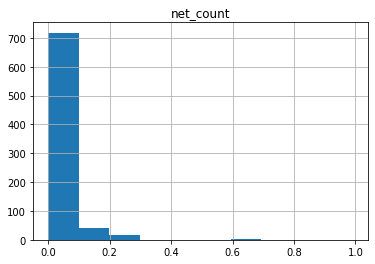

In [56]:
dataset_ixp.hist()

### Ajout de la colonne `ix_count` [AS]

In [57]:
max_ix_count = net['ix_count'].max()
ix_count_scaled = [len(DiGraph[i])/max_ix_count for i in DiGraph.nodes() if i > 0]

dataset_as['ix_count'] = ix_count_scaled

<AxesSubplot:>

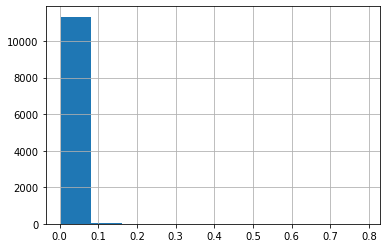

In [58]:
dataset_as['ix_count'].hist()

### Ajout de la colonne `port_capacity` <br>
   - 1) On divise par port_max de l'AS
   - 2) On divise par la port_max indépendament entre IXP et AS

In [59]:
max_portAS = net['port_capacity'].max()
dataset_as['port_capacity'] = net['port_capacity']/max_portAS

In [60]:
dataset_as.head()

,info_scope,info_traffic,ix_count,port_capacity
asn,,,,
20940,1.000000,1.000000,0.515244,0.893224
31800,1.000000,0.157895,0.042683,0.000253
22822,1.000000,0.736842,0.253049,0.272934
3303,0.666667,0.736842,0.152439,0.015179
6079,0.666667,0.736842,0.018293,0.013775


In [61]:
max_portIXP = ix['port_capacity'].max()

list_port_scaled = ix['port_capacity']/max_portIXP
print(list_port_scaled)

dataset_ixp['port_capacity'] = ix['port_capacity']/max_portIXP

asn
-1      0.280998
-2      0.229079
-3      0.159643
-4      0.077176
-5      0.141351
          ...   
-886    0.002599
-888    0.015741
-890    0.000044
-892    0.001592
-893    0.000219
Name: port_capacity, Length: 780, dtype: float64


In [62]:
dataset_ixp.head()

,net_count,port_capacity
0,0.249809,NaN
1,0.184110,NaN
2,0.131398,NaN
3,0.077922,NaN
4,0.092437,NaN


### Ajout de la colonne `info_ratio` [AS]

In [63]:
net['info_ratio'].value_counts()

Balanced           3494
Mostly Inbound     3476
Not Disclosed      1965
Mostly Outbound    1078
Heavy Inbound       803
Heavy Outbound      397
                    194
Name: info_ratio, dtype: int64

In [64]:
nb_info_ratio = 5
info_ratio_scaled = net['info_ratio'].map({"Heavy Inbound":1/nb_info_ratio, "Mostly Inbound":2/nb_info_ratio,
                                           "Balanced":3/nb_info_ratio, "Not Disclosed":3/nb_info_ratio,
                                           "":3/nb_info_ratio, "Mostly Outbound":4/nb_info_ratio,
                                           "Heavy Outbound":1})

In [65]:
dataset_as['info_ratio'] = info_ratio_scaled
dataset_as['info_ratio'].value_counts()

0.6    5653
0.4    3476
0.8    1078
0.2     803
1.0     397
Name: info_ratio, dtype: int64

In [66]:
dataset_as.head()

,info_scope,info_traffic,ix_count,port_capacity,info_ratio
asn,,,,,
20940,1.000000,1.000000,0.515244,0.893224,1.0
31800,1.000000,0.157895,0.042683,0.000253,0.2
22822,1.000000,0.736842,0.253049,0.272934,0.8
3303,0.666667,0.736842,0.152439,0.015179,0.4
6079,0.666667,0.736842,0.018293,0.013775,0.4


### Ajout de la colonne `policy_general` [AS]

In [67]:
net['policy_general'].value_counts()

Open           9217
Selective      1921
Restrictive     167
                 71
No               31
Name: policy_general, dtype: int64

In [68]:
nb_policy_general = 4
policy_general_scaled = net['policy_general'].map({"Open":1/nb_policy_general, "Selective":2/nb_policy_general,
                                                   "Restrictive":3/nb_policy_general, "No":1,
                                                   "":1/nb_policy_general})

In [69]:
dataset_as['policy_general'] = policy_general_scaled
dataset_as['policy_general'].value_counts()

0.25    9288
0.50    1921
0.75     167
1.00      31
Name: policy_general, dtype: int64

### Ajout de la colonne `info_type` [AS]

In [70]:
net['info_type'].value_counts()

Cable/DSL/ISP           4993
NSP                     2135
Content                 1226
Not Disclosed           1179
Enterprise               625
Educational/Research     500
Non-Profit               320
Route Server             258
                         122
Network Services          27
Route Collector           12
Government                10
Name: info_type, dtype: int64

In [71]:
info_type_classified = net['info_type'].map({"Cable/DSL/ISP":0, "NSP":1, "Content":2, "":0,
                                             "Not Disclosed":0, "Enterprise":3, "Educational/Research":4,
                                             "Non-Profit":5, "Route Server":6, "Network Services":7,
                                             "Route Collector":8, "Government":9})

In [72]:
dataset_as['info_type'] = info_type_classified
dataset_as['info_type'].value_counts()

0    6294
1    2135
2    1226
3     625
4     500
5     320
6     258
7      27
8      12
9      10
Name: info_type, dtype: int64

In [73]:
dataset_as.head()

,info_scope,info_traffic,ix_count,port_capacity,info_ratio,policy_general,info_type
asn,,,,,,,
20940,1.000000,1.000000,0.515244,0.893224,1.0,0.25,2
31800,1.000000,0.157895,0.042683,0.000253,0.2,0.25,5
22822,1.000000,0.736842,0.253049,0.272934,0.8,0.50,2
3303,0.666667,0.736842,0.152439,0.015179,0.4,0.50,0
6079,0.666667,0.736842,0.018293,0.013775,0.4,0.50,0


## Final dataset scaled

Here are the 7 node-features scaled, ready to be given to the GCN.

| Attribute name        | Meaning           | Possible values  |
| :-------------:       |:---------------:  | :--------------: |
| **info_scope** (AS) | origine géographique de la mesure | `1/3` `2/3` `1`
| **info_traffic** | ordre de grandeur du traffic | `1/18` `2/18` `3/18` `4/18` `5/18` `6/18` `7/18` `8/18` `9/18` `10/18` `11/18` `12/18` `13/18` `14/18` `15/18` `16/18` `17/18` `1`
| **ix_count** (AS) | nombre d'IXP auquel l'AS se connecte | int scaled (`0` to `1`)
| **port_capacity** (both) | bande passante d'un port | std value of port_capacity (from `0` to `1`)
| **info_ratio** (AS) | politique de communication de l'AS | `0.2` `0.4` `0.6` `0.8` `1` 
| **policy_general** |politique de traffic de l'AS | `0.25` `0.5` `0.75` `1`
| **info_type** (AS)    | classification de l'AS (NaN pour un IXP) | `0`    `1` `2` `3` `4` `5` `6` `7` `8` `9`
| **net_count** (IXP) | nombre d'AS auquel l'AS se connecte | int scaled (`0` to `1`)

### Exportation des données :
- Table `dataset_as` pour les **AS feature** <br>
- Table `dataset_ixp` pour les **IXP feature** <br>
- Graphe `G_bipartite` pour le **graphe biparti**

In [74]:
# Exportation des données
suffix = '_pDB_'

dataset_as.to_csv('data_GCN/dataset_AS'+suffix+'.csv', index=False)
dataset_ixp.to_csv('data_GCN/dataset_IXP'+suffix+'.csv', index=False)

nx.write_gpickle(G_bipartite.copy(), 'data_GCN/graph'+suffix+'.pickle')